# Generate some simple geometry for a tube

As a surgical simulator we want to travel the length of the tube and create images from a camera point.

In [78]:
import numpy as np
import math
import matplotlib.pyplot as plt
#%matplotlib qt

Start by creating a line in 3D.

In [79]:
stepSize = 0.25
smoothness = 0.8
length = 100
endPoint = np.asarray([0,0,0])
centerLine = [endPoint]
randomDir = np.asarray([0,0,1])
for i in range(length):
    randomDir = randomDir + (np.random.rand(3)*2 -
                             np.asarray([smoothness, smoothness, smoothness]))
    randomDir = randomDir / np.linalg.norm(randomDir)
    endPoint = endPoint + (stepSize * randomDir)
    centerLine.append(endPoint)
#centerLine

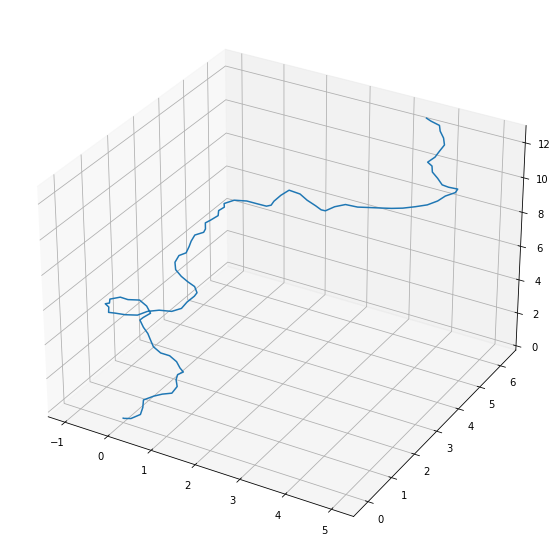

In [80]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = [a[0] for a in centerLine]
y = [a[1] for a in centerLine]
z = [a[2] for a in centerLine]
ax.plot(x,y,z)
plt.show()

Instead of just using that line its better to smooth it first and generate a spline interpolation instead.

In [81]:
from scipy import interpolate
oldNumPoints = len(centerLine)
newNumPoints = oldNumPoints * 5
x = [a[0] for a in centerLine]
y = [a[1] for a in centerLine]
z = [a[2] for a in centerLine]
tck, u = interpolate.splprep([x,y,z], s=1)
u_fine = np.linspace(0,1,newNumPoints)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)
centerLine = []
for i in range(newNumPoints):
    centerLine.append(np.asarray([x_fine[i], y_fine[i], z_fine[i]]))

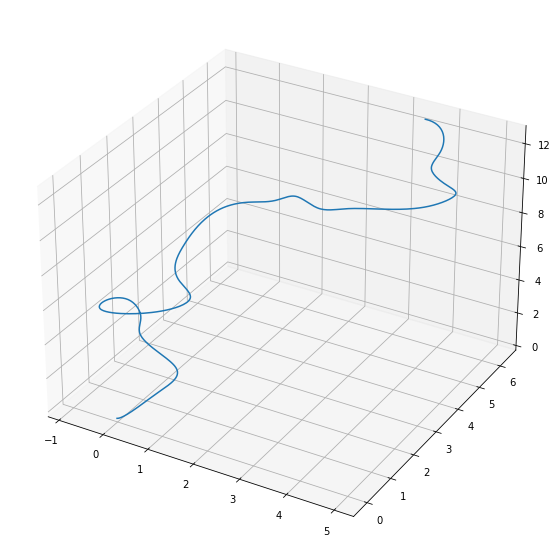

In [82]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = [a[0] for a in centerLine]
y = [a[1] for a in centerLine]
z = [a[2] for a in centerLine]
ax.plot(x,y,z)
plt.show()

Compute a vector that is orthogonal to the centerline at each point (normal vector) and place a circle of points there. Lets also change the radius using some frequency and amplitude.

In [83]:
radius = 0.3
circlePoints = 10
def radiusByLength(length, x, radius):
    amplitude = radius / 3
    freq = 1.0 /(length / 4)
    return radius + amplitude * np.sin(freq*x*2*math.pi)
circles = []
realLength = 0
for i in range(len(centerLine)-1):
    v = centerLine[i+1] - centerLine[i]
    realLength += np.linalg.norm(v)
for i in range(len(centerLine)-1):
    v = centerLine[i+1] - centerLine[i]
    v = v / np.linalg.norm(v)
    r = np.random.rand(3)-0.5
    r = r / np.linalg.norm(r)
    t = np.cross(v, r)
    b = t / np.linalg.norm(t)
    # now use b to place our circle
    tmp_radius = radiusByLength(realLength, i/len(centerLine)*realLength, radius)
    circle = []
    for j in range(circlePoints):
        angleOfRotation = j*(2*math.pi/circlePoints)
        b2 = b*np.cos(angleOfRotation) + (np.cross(v,b)*np.sin(angleOfRotation) + v*(np.dot(v,b)*(1-np.cos(angleOfRotation))))
        b2 = b2 / np.linalg.norm(b2)
        b2 = tmp_radius * b2
        circle.append(centerLine[i+1] + b2)
    circle.append(circle[0])
    circles.append(circle)

Show all the circles together with the line.

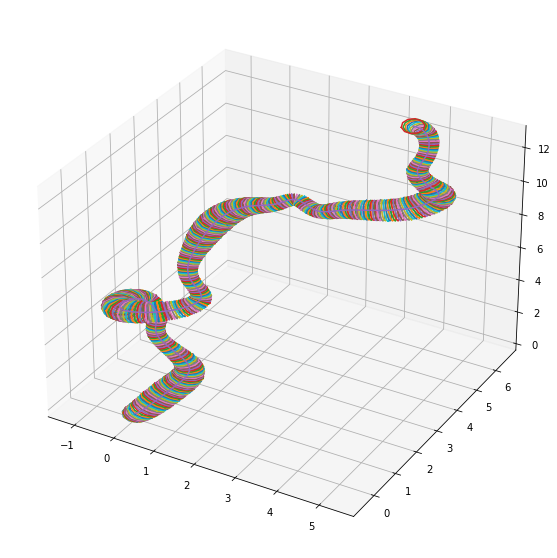

In [84]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = [a[0] for a in centerLine]
y = [a[1] for a in centerLine]
z = [a[2] for a in centerLine]
for i in range(len(circles)):
    circle = circles[i]
    xc = [a[0] for a in circle]
    yc = [a[1] for a in circle]
    zc = [a[2] for a in circle]
    ax.plot(xc, yc, zc)
ax.plot(x, y, z)
plt.gca().set_aspect('auto')
plt.show()


Now we can create a triangulated surface that connects the points with each other. For this operation a pair of points from each circle are connected to another pair of points in the next circle. Problem is that circles might be roated relative to each other (based on the random vector used to define vector b above).

In [85]:
# put all the circle points into a vertices array
vertices = []
for i in range(len(circles)):
    circle = circles[i]
    for j in range(len(circle)):
        vertices.append(circle[j])

# For each circle compute the best shift in indices to prevent bad triangles
shifts = np.asarray(list(range(len(circles))))
def computeDistance(shift, numPoints, circleA, circleB):
    distance = 0
    for i in range(numPoints):
        distance += np.linalg.norm(np.asarray(circleA[i]) - np.asarray(circleB[(i+shift)%(numPoints)]))
    return distance

def computeBetterShifts(shifts):
    for circleID in range(len(shifts)-1):
        bestShift = shifts[circleID]
        s = circleID*(circlePoints+1)
        verts1 = vertices[s:s+(circlePoints+1)]
        s = (circleID+1)*(circlePoints+1)
        verts2 = vertices[s:s+(circlePoints+1)]
        bestShiftDistance = computeDistance(bestShift, circlePoints+1, verts1, verts2)
        for shift in range(circlePoints):
            distance = computeDistance(shift, circlePoints+1, verts1, verts2)
            if distance < bestShiftDistance:
                bestShift = shift
                bestShiftDistance = distance
        #print("best shift is: %d" % bestShift)
        shifts[circleID] = bestShift
    return shifts

shifts = computeBetterShifts(shifts)


In [86]:
triangles = []
# test with a simple double ring first
for circleID in range(len(circles)-1):
    # for the current circle go through all its points and connect to the next circle
    for i in range(circlePoints+1):
        pidx1r1 = circleID*(circlePoints+1) + i
        pidx2r1 = circleID*(circlePoints+1) + ((i+1)%(circlePoints+1))

        pidx1r2 = (pidx1r1+shifts[circleID])%(circlePoints+1)
        pidx2r2 = (pidx1r2+1)%(circlePoints+1)
        pidx1r2 = pidx1r2 + (circlePoints+1)*(circleID+1)
        pidx2r2 = pidx2r2 + (circlePoints+1)*(circleID+1)
        #if circleID == 0:
        #    print(pidx1r1, pidx2r1, pidx1r2, pidx2r2)
        triangles.append([pidx1r1, pidx2r1, pidx1r2])
        triangles.append([pidx1r2, pidx2r1, pidx2r2])
#triangles

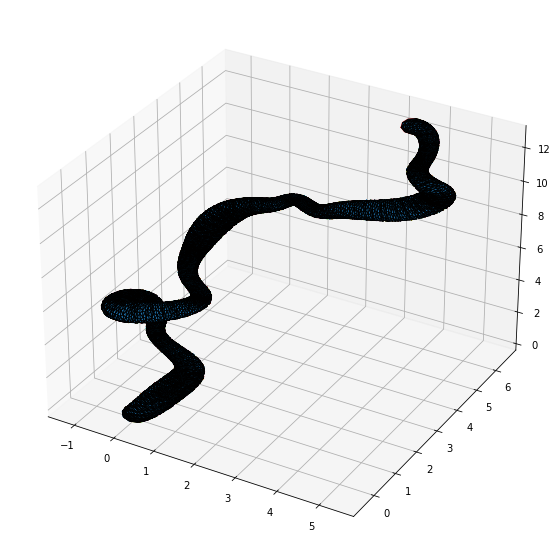

In [87]:
# plot the triangles together with everything else
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import LightSource

# should be array of coordinates
trigDisplay = []
for i in range(len(triangles)):
    trig = [list(vertices[triangles[i][0]]), list(vertices[triangles[i][1]]), list(vertices[triangles[i][2]])]
    trigDisplay.append(trig)
#print(trigDisplay)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = [a[0] for a in centerLine]
y = [a[1] for a in centerLine]
z = [a[2] for a in centerLine]
for i in range(len(circles)):
    circle = circles[i]
    xc = [a[0] for a in circle]
    yc = [a[1] for a in circle]
    zc = [a[2] for a in circle]
    ax.plot(xc, yc, zc)
ax.plot(x, y, z)
plt.gca().set_aspect('auto')
mesh = Poly3DCollection(trigDisplay, alpha=1.0)
mesh.set_edgecolor('k')
ls = LightSource(azdeg=45.0, altdeg=90.0)
#rgb = ls.blend_hsv(rgb=ls.shade(facearray, plt.cm.Reds), intensity=ls.shade_normals(normals, fraction=0.25))
ax.add_collection(mesh)

#ax.set_xlim([0,10])
#ax.set_ylim([0,10])
#ax.set_zlim([0,10])

plt.show()

# Write the surface as an STL file

The STL file can be imported in external programs for rendering purposes.

In [88]:
# we should probably create each triangle twice for inside and outside shading
l = len(triangles)
for i in range(l):
    triangles.append([triangles[i][2], triangles[i][1], triangles[i][0]])

def normal(p1, p2, p3):
    v1 = np.asarray(p2) - np.asarray(p1)
    v2 = np.asarray(p3) - np.asarray(p1)
    return np.cross(v1, v2)

# export all the triangles to an stl file
def saveAsSTL(fname, vertices, triangles):
    with open(fname, 'w') as f:
        f.write('solid shai-hulud\n')
        for i in range(len(triangles)):
            n = normal(vertices[triangles[i][0]], vertices[triangles[i][1]], vertices[triangles[i][2]])
            f.write('facet normal %f %f %f\n' % (n[0], n[1], n[2]))
            f.write('outer loop\n')
            for j in range(3):
                f.write('vertex %f %f %f\n' % (vertices[triangles[i][j]][0], vertices[triangles[i][j]][1], vertices[triangles[i][j]][2]))
            f.write('endloop\n')
            f.write('endfacet\n')
        f.write('endsolid\n')
saveAsSTL('/tmp/shai-hulud.stl', vertices, triangles)

# Summary

At this point we have seen everything of interest. The above steps are not the easiest but they have the advantage that apart from the spline interpolation no magick library calls are used.

A better way to create the surface might have been one where we start with a label field that contains values '1' at voxel that are inside the tube and values '0' at voxels that are in the background. With such a label field we can perform a marching cube based surface reconstruction on the voxel grid. Such an approach would certainly use up more memory as the resolution of the surface would depend on the resolution of the label field.